# **OK!**

# **Modelo de Sistema de Recomendación - GRUPOREFERENCIA**
# **Algoritmo KNeighborsClassifier**

In [1]:
import os
import psutil

# Memoria
print(f"Memoria total: {psutil.virtual_memory().total / 1e9:.2f} GB")  # Si muestra >16GB → probablemente remoto

# CPU
print(f"Núcleos lógicos: {os.cpu_count()}")  # >8 cores → servidor dedicado

Memoria total: 16.62 GB
Núcleos lógicos: 8


In [ ]:
import pandas as pd
import numpy as np
import random
import joblib

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score,
                             matthews_corrcoef,
                             cohen_kappa_score)
from sklearn.neighbors import KNeighborsClassifier

In [3]:
from dav_cas.tools.eva_mod import classification_report_df
from dav_cas.tools.graficos import conf_matrix_normalized_sn

In [4]:
# Semillas para reproducibilidad
SEED = 7
SEED_SPLIT = 7
os.environ['PYTHONHASHSEED'] = f'{SEED}'  # Para operaciones hash en Python
np.random.seed(SEED)                   # Semilla para numpy
random.seed(SEED)

In [5]:
basedir = os.getcwd()

## **1- Carga de los datos SB11_SBPro_UDENAR_00_02:**

## **(Data #3)**

In [6]:
# MEJOR DATA # 3
CAR_NOM = '00' # Características nominales
CAR_ORD = '02' # Características ordinales

In [7]:
X = pd.read_csv(os.path.join(basedir, f'data/data_icfes/SB11_SBPro/SB11_SBPro_UDENAR_{CAR_NOM}_{CAR_ORD}.csv'))

## **2- Carga los valores de 'y' (GRUPOREFERENCIA):**

In [8]:
y = pd.read_csv(os.path.join(basedir, 'data/data_icfes/SB11_SBPro/y_GRUPOREFERENCIA_clase.csv'))

## **3- Dividir el dataset en entrenamiento y prueba:**

In [9]:
# División estratificada en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED_SPLIT)

## **4- Selección de Características:**

In [ ]:
%run -i "Selección de características.ipynb"

In [11]:
dic_nom_features = {'00': nominal_features_00,
                    '01': nominal_features_01,
                    '02': nominal_features_02}

In [12]:
dic_ord_features = {'00': dic_car_ord_00,
                    '01': dic_car_ord_01,
                    '02': dic_car_ord_02}

In [13]:
# Características Nominales
nominal_features = dic_nom_features[CAR_NOM]
# Características Ordinales
ordinal_features = list(dic_ord_features[CAR_ORD].keys())
# Características Numéricas
numerical_features = numeric_features

## **5- Configuración del Preprocesamiento:**

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        # Codificar variables categóricas nominales
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        # Codificar variables categóricas ordinales
        ('ordinal', OrdinalEncoder(), ordinal_features),
        # Escalar variables numéricas
        ('numerico', RobustScaler(), numerical_features)
    ],
    remainder='drop'  # Descarta columnas no especificadas (opcional)
    # remainder='passthrough'  # Mantiene las columnas no especificadas
)

## **6- Configuración de Pipeline (Tuberías):**

In [15]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())  # Modelo
    ])

## **7- Búsqueda de hiperparámetros:**

In [16]:
param_grid = {'classifier__n_neighbors': list(range(3, 18, 2)), # Valores impares para evitar empates
              'classifier__weights': ['uniform', 'distance'], # con weights='distance' prioriza muestras cercanas y relevantes para clases desbalanceadas. 'uniform' sirve como línea base
              'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], # ball_tree eficiente para datos > 10 dimensiones (tras codificar variables categóricas)
              'classifier__metric': ['minkowski', 'euclidean', 'manhattan'],  # Distancias comunes para KNN
              'classifier__p': [1, 2], # Parámetro para la métrica Minkowski (p=1 es Manhattan, p=2 es Euclidiana)
              'classifier__leaf_size': [15, 20, 30, 40, 50] # Tamaño de hoja para algoritmos de árbol.  Valores bajos (20-50) aumentan precisión a costa de velocidad (aceptable para 6k registros)
              }


## **8- Configuración de la búsqueda:**

#### **Configurar Stratified K-Fold (5 folds)**

StratifiedKFold para mantener la distribución de clases en cada fold HalvingGridSearchCV optimiza la búsqueda de hiperparámetros con eliminación competitiva

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [18]:
# Configurar HalvingGridSearchCV
search = HalvingGridSearchCV(
    pipeline,
    param_grid,
    resource='n_samples',
    max_resources=700,
    factor=5,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=SEED,
    aggressive_elimination=False, # Prioriza usar todos los recursos (aggressive_elimination=False), asegurando que los mejores candidatos se evalúen con max_resources
    return_train_score=True,
    refit=True,
    verbose=0
)

## **9- Entrenamiento:**

In [19]:
%%time
search.fit(X_train, y_train["GRUPOREFERENCIA"].values)

CPU times: user 21.8 s, sys: 764 ms, total: 22.5 s
Wall time: 1min 42s


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('nominal',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['FAMI_TIENECOMPUTADOR',
                                                                                 'ESTU_GENERO',
                                                                                 'FAMI_TIENESERVICIOTV',
                                                                                 'FAMI_TIENEINTERNET',
                                                                                 'FAMI_TIENEHORNOMICROOGAS',
                                                                                 'FAMI_TIENELAVADORA',
                                                                                 'FAMI_TIENEAUTOMO...
                    factor=5, max_resources=700, n_jobs=-1,
                    param_grid={'classifier__algorithm': ['auto', 'ball_tree',
                                                          'kd_tree', 'brute'],
                                'classifier__leaf_size': [15, 20, 30, 40, 50],
                                'classifier__metric': ['minkowski', 'euclidean',
                                                       'manhattan'],
                                'classifier__n_neighbors': [3, 5, 7, 9, 11, 13,
                                                            15, 17],
                                'classifier__p': [1, 2],
                                'classifier__weights': ['uniform', 'distance']},
                    random_state=7, scoring='f1_macro')

In [20]:
joblib.dump(search, os.path.join(basedir, './models/best_model_KNeighborsClassifier_search.pkl'))

['/home/jacques/Documentos/ml_study/FINALES/./models/best_model_KNeighborsClassifier_search.pkl']

## **10- Resultados:**

In [21]:
print(f"Mejores parámetros: {search.best_params_}")
print(f"Mejor puntuación: {search.best_score_}")

Mejores parámetros: {'classifier__algorithm': 'auto', 'classifier__leaf_size': 20, 'classifier__metric': 'minkowski', 'classifier__n_neighbors': 7, 'classifier__p': 2, 'classifier__weights': 'distance'}
Mejor puntuación: 0.12876102588320384


#### **Mejores parámetros del modelo:**

In [22]:
best_model = search.best_estimator_
modelo_inside = best_model.named_steps['classifier']
modelo_inside.get_params()

{'algorithm': 'auto',
 'leaf_size': 20,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'distance'}

## **11- Evaluación final con Test:**

In [ ]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print(f"\nReporte de clasificación:")
classification_report_df(y_test, y_pred, precisión=4)

print(f"\nF1-score ma: {f1_score(y_test, y_pred, average='macro'):.4f}")

print(f"\nMatthews corr: {matthews_corrcoef(y_test, y_pred):.4f}")

print(f"\nCohen kappa: {cohen_kappa_score(y_test, y_pred):.4f}")



Reporte de clasificación:


,class,precision,recall,f1-score,support
0,0,0.1558,0.1667,0.1611,144
1,1,0.4400,0.3056,0.3607,36
2,2,0.1290,0.0702,0.0909,57
3,3,0.0000,0.0000,0.0000,74
4,4,0.0000,0.0000,0.0000,43
5,5,0.1429,0.0462,0.0698,65
6,6,0.0625,0.0227,0.0333,44
7,7,0.1724,0.1099,0.1342,91
8,8,0.1429,0.0784,0.1013,51
9,9,0.2762,0.3299,0.3006,288



F1-score ma: 0.1412

Matthews corr: 0.0915

Cohen kappa: 0.0898


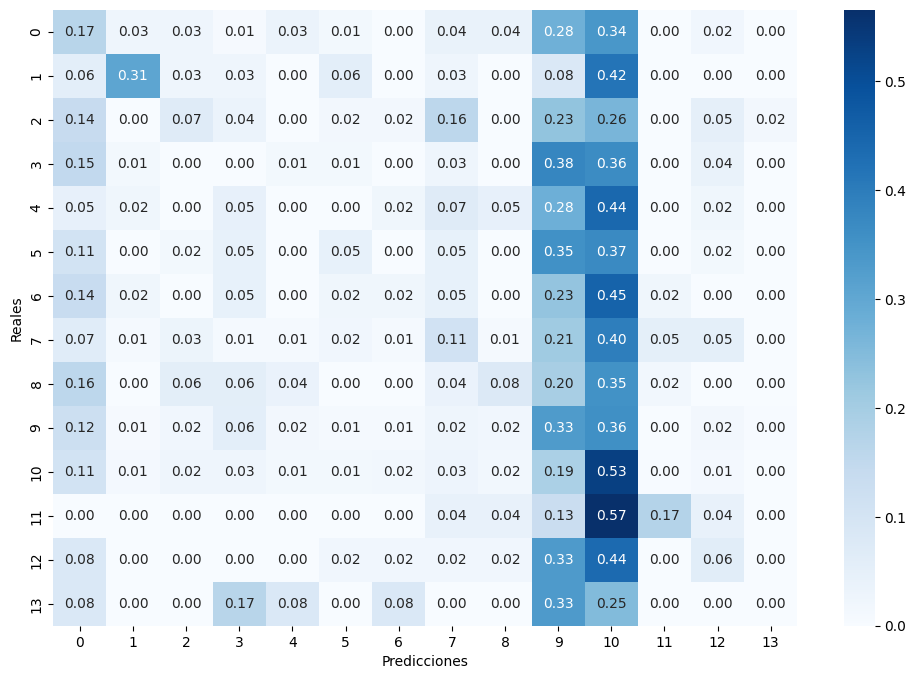

Matriz de Confusión Normalizada (por fila)
Modelo KNeighborsClassifier (GRUPOREFERENCIA)


In [24]:
conf_matrix_normalized_sn(y_test, y_pred)
print("Matriz de Confusión Normalizada (por fila)\nModelo KNeighborsClassifier (GRUPOREFERENCIA)")

## **12- Entrenamiento final con todos los datos X:**

In [25]:
from sklearn.base import clone

best_model = search.best_estimator_

# Reentrenar con TODOS los datos (train + test)
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

final_model = clone(best_model)
final_model.fit(X_full, y_full["GRUPOREFERENCIA"].values)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FAMI_TIENECOMPUTADOR',
                                                   'ESTU_GENERO',
                                                   'FAMI_TIENESERVICIOTV',
                                                   'FAMI_TIENEINTERNET',
                                                   'FAMI_TIENEHORNOMICROOGAS',
                                                   'FAMI_TIENELAVADORA',
                                                   'FAMI_TIENEAUTOMOVIL',
                                                   'COLE_NATURALEZA',
                                                   'COLE_GENERO',
                                                   'COLE_CALENDARIO',
                                                   'FAMI_TRABAJOLABORPADRE',
                                                   'FAMI_TRABAJOLABORMADRE']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['FAMI_ESTRATOVIVIENDA',
                                                   'FAMI_PERSONASHOGAR']),
                                                 ('numerico', RobustScaler(),
                                                  ['EDAD', 'LAT_COLE',
                                                   'LON_COLE',
                                                   'PUNT_LECTURA_CRITICA',
                                                   'PUNT_MATEMATICAS',
                                                   'PUNT_SOCIALES_CIUDADANAS',
                                                   'PUNT_C_NATURALES',
                                                   'PUNT_INGLES'])])),
                ('classifier',
                 KNeighborsClassifier(leaf_size=20, n_neighbors=7,
                                      weights='distance'))])

## **13- Guardar modelo final:**

In [26]:
joblib.dump(final_model, os.path.join(basedir, './models/best_model_KNeighborsClassifier_final.pkl'))

['/home/jacques/Documentos/ml_study/FINALES/./models/best_model_KNeighborsClassifier_final.pkl']

## **14- Predicción con el modelo final:**

In [27]:
X_test.iloc[7:8]

,ESTU_GENERO,FAMI_TRABAJOLABORPADRE,FAMI_TRABAJOLABORMADRE,FAMI_TIENEINTERNET,FAMI_TIENESERVICIOTV,FAMI_TIENECOMPUTADOR,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,FAMI_TIENEHORNOMICROOGAS,COLE_CALENDARIO,...,FAMI_ESTRATOVIVIENDA,FAMI_PERSONASHOGAR,EDAD,LAT_COLE,LON_COLE,PUNT_LECTURA_CRITICA,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_INGLES
579,F,NO SABE,"TRABAJA EN EL HOGAR, NO TRABAJA O ESTUDIA",NO,NO,NO,NO,NO,NO,A,...,SIN ESTRATO O ESTRATO 1,1 A 4,16.0,0.829022,-77.629513,55.0,67.0,64.0,63.0,49.0


In [29]:
model = joblib.load(os.path.join(basedir, './models/best_model_KNeighborsClassifier_final.pkl'))
model.predict(X_test.iloc[7:8])

array([10])